In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pytorch_wavelets as pw

In [5]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))])
#from online: the mean of MNIST is 0.1307, the std 0.3081
# https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457

trainset = torchvision.datasets.MNIST(root= '../data', train=True,
                                        download=True, transform=transform)
#keep batches in 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../data', train=False,
                                        download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=True, num_workers=2)

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(2304, 128)
        self.fc2 = nn.Linear(128, 10)
        self.xfm = pw.DWTForward(J = 2, wave = 'haar',mode = 'zero')
        #haar wavelet transform, zero padding
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        yl,_ = self.xfm(x)
        x = yl
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

net = Net()

In [10]:
net = Net()
train_error = []
test_acc = []

#loss function
criterion = nn.CrossEntropyLoss()
#stochastic gradient descent
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


for epoch in range(10):  # loop/over the dataset multiple times

    running_loss = 0.0
    num_images = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        num_images += inputs.size(1)
        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / num_images))
            train_error.append(running_loss / num_images)
            running_loss = 0.0
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        test_acc.append(correct/total)
        

print('Finished Training')

[1,  1000] loss: 1.020
[1,  2000] loss: 0.228
[1,  3000] loss: 0.104
[1,  4000] loss: 0.067
[1,  5000] loss: 0.043
[1,  6000] loss: 0.033
[1,  7000] loss: 0.023
[1,  8000] loss: 0.022
[1,  9000] loss: 0.019
[1, 10000] loss: 0.015
[1, 11000] loss: 0.014
[1, 12000] loss: 0.011
[1, 13000] loss: 0.013
[1, 14000] loss: 0.010
[1, 15000] loss: 0.010
[2,  1000] loss: 0.119
[2,  2000] loss: 0.059
[2,  3000] loss: 0.038
[2,  4000] loss: 0.028
[2,  5000] loss: 0.023
[2,  6000] loss: 0.019
[2,  7000] loss: 0.015
[2,  8000] loss: 0.015
[2,  9000] loss: 0.013
[2, 10000] loss: 0.010
[2, 11000] loss: 0.010
[2, 12000] loss: 0.008
[2, 13000] loss: 0.008
[2, 14000] loss: 0.007
[2, 15000] loss: 0.007
[3,  1000] loss: 0.094
[3,  2000] loss: 0.051
[3,  3000] loss: 0.034
[3,  4000] loss: 0.020
[3,  5000] loss: 0.019
[3,  6000] loss: 0.012
[3,  7000] loss: 0.014
[3,  8000] loss: 0.010
[3,  9000] loss: 0.009
[3, 10000] loss: 0.011
[3, 11000] loss: 0.009
[3, 12000] loss: 0.006
[3, 13000] loss: 0.007
[3, 14000] 

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the ' + str(total) + ' test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %


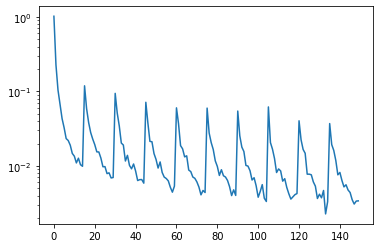

In [13]:
plt.figure()
plt.semilogy(train_error)